In [1194]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from UtilityGraph import *
from Defence import *
from Corruption import *
from UtilityMLP import *
import random
from collections import deque
from scipy.stats import *
import copy
import seaborn as sns
from Test import *
import math

In [1195]:
Seed = 2001  # for reproducibility
random.seed(Seed)
np.random.seed(Seed) 
torch.manual_seed(Seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Seed)
    torch.cuda.manual_seed_all(Seed)


In [1196]:
# Graph
required_probability=0.9999
num_nodes, G,A,pos,r_c=build_random_graph(40,required_probability,fix_num_nodes=True)
print("num_nodes:",num_nodes)

percentageCorrupt = 1/num_nodes*7   #Percentage of corrupt clients




var = 30                  # Standard deviation for Gaussian noise
mean = 1                    # Mean for Gaussian noise
Target = np.random.randint(1, num_nodes) # Target client for copycat attack
scale = 1
typeAttack = 0              # 0: No attack, 1: Gaussian noise, 2: Copycat attack, 3: Gaussian addative noise attack, 4: LIE attack

corrupt = True              #If True, corrupt clients are included
CorruptClients = CorruptGeneration(percentageCorrupt, corrupt, num_nodes) #Selection of Corrupt Clients
CorruptClients = np.array(CorruptClients, dtype=int)

lying_nodes = np.where(CorruptClients == 1)[0]
true_nodes = [i for i in range(num_nodes) if i not in lying_nodes]

test1 = 0
# Data
Data = np.zeros([num_nodes,1])
RealMean = 25
RealVar = 500
for i in range(num_nodes):
    Data[i] = np.random.normal(RealMean, np.sqrt(RealVar))
    test1 += G.degree(i)

print(test1/num_nodes)

Control = Data.copy()

neighbors_dict = {}
for ln in lying_nodes:
    neighbors_dict[ln] = list(G.neighbors(ln))

print("Neighbors of lying nodes:", neighbors_dict)



num_nodes: 40
IteNumber of Corrupt nodesration 7, Corrupt nodes: [ 6 18  0 19  5 34 31]
8.75
Neighbors of lying nodes: {0: [4, 15, 19, 20, 22, 29, 34], 5: [7, 17, 24, 32, 36, 38, 39], 6: [2, 3, 4, 8, 9, 10, 14, 15, 19, 26, 27, 28, 29, 37], 18: [13, 17, 20, 21, 24, 30, 31, 32, 39], 19: [0, 3, 4, 6, 9, 13, 14, 15, 27, 29, 34, 37], 31: [13, 17, 18, 20, 21, 24, 32, 39], 34: [0, 4, 14, 15, 19, 22, 27, 29, 37]}


In [1197]:
def normpdf(x, mn, var):
    denom = (2 * np.pi * var)**0.5 
    num = np.exp(-((x - mn)**2) / (2 * var + 1e-6)) 
    return num / (denom + 1e-6)

In [1198]:
# Define the normal probability density function
def shownormpdf(mn, var):
    # Step 2: Create x values (input range)
    x = np.linspace(-10, 20, 500)  # Adjust the range to better visualize the Gaussian

    # Step 3: Compute y values (apply the function)
    y = normpdf(x,mn,var)

    # Step 4: Plot the function
    plt.plot(x, y, label='Normal PDF (mean={mn}, variance={var})'.format(mn=mn, var=var))

    # Step 5: Customize the plot
    plt.title("Plot of Normal Probability Density Function")  # Add title
    plt.xlabel("x")  # Label x-axis
    plt.ylabel("f(x)")  # Label y-axis
    plt.axhline(0, color='black', linewidth=0.5)  # Add x-axis line
    plt.axvline(0, color='black', linewidth=0.5)  # Add y-axis line
    plt.grid(True)  # Add grid
    plt.legend()

    # Step 6: Show the plot
    plt.show()
    return 0


In [1199]:
def nodeSelection(max_iters, num_nodes):
    #Selecting nodes for its turn
    nodes_list = []
    for i in range(max_iters):
        nodes_list.append(np.random.randint(0,num_nodes))
    return nodes_list

In [1200]:
def iterative_thresholding(values, initial_threshold, tol=1e-3):
    """
    Performs iterative (two-group) thresholding on 'values' array.

    Steps:
    1) Split values into G1 (those > T_old) and G2 (≤ T_old).
    2) m1 = mean(G1), m2 = mean(G2)
    3) T_new = (m1 + m2)/2
    4) Repeat until |T_new - T_old| < tol or we reach max_iter.

    :param values: 1D np.array of floats
    :param initial_threshold: float, starting threshold
    :param tol: float, stopping tolerance
    :param max_iter: int, maximum iteration count
    :return: float, the final threshold
    """
    T_old = initial_threshold

    G1 = values[values > T_old]
    G2 = values[values <= T_old]

    if G1.size == 0 or G2.size == 0:
        T_new = T_old
    else:
        m1 = np.mean(G1)
        m2 = np.mean(G2)
        T_new = 0.5 * (m1 + m2)
    
    # if abs(T_new - T_old) < tol:
    #     break
    T_old = T_new

    return T_old


In [1201]:
def check_U_values(theta_now, theta_prev, i, G, mu, num_nodes, count):
    """
    Computes u_{i,j}(t) and U_{i,j}(t) for a *single* iteration t, 
    given the current and previous theta = calc_dual arrays.
    
    :param theta_now:   2D array, theta_{k,l}(t+1)
    :param theta_prev:  2D array, theta_{k,l}(t)
    :param i:           Node index for which we compute these values
    :param G:           Graph
    :param mu:          1/eta, or the 'stepsize' used in eq. (14b)
    :param num_nodes:   Number of nodes
    :return: A 1D array U_vals, where U_vals[j] = U_{i,j}(t).
             (We only fill j if j is in neighbors(i); otherwise 0.)
    """
    u = np.zeros(num_nodes)  # will hold u_{i,j}(t) for j in neighbors(i)
    U = np.zeros(num_nodes)  # will hold U_{i,j}(t) likewise

    mu = mu / count
        
    # 1) Compute all u_{i,j}(t) for j in N_i
    for j in G.neighbors(i):
        # eq. (14b): u_{i,j}(t) = 1/eta(t) [ theta_{i,j}(t+1) - theta_{i,j}(t) ]
        # We'll treat 'mu' as 1/eta with 'count' as the (t).
            u[j] = mu * (theta_now[j][i] - theta_prev[j][i])
    
    # 2) For each j, we need the median of { u_{i,l}(t) : l in N_i \ j }.
    #    Then U_{i,j}(t) = || u_{i,j}(t) - median(...) ||_∞.
    #    In 1D, the L∞-norm is just absolute value.
    for j in G.neighbors(i):
        # collect neighbors except j
        neighbor_u_vals = []
        for l in G.neighbors(i):
            if l != j:
                neighbor_u_vals.append(u[l])
        median_val = np.median(neighbor_u_vals) if neighbor_u_vals else 0.0
        U[j] = abs(u[j] - median_val)
    
    return U

In [1202]:
def PDMM(
    Data, G, avg_temp, tolerance, c, max_iters, Control,
    averaging, Timer, K_decision, rejection_threshold, perm_threshold
):
    """
    PDMM with attacker detection/avoidance, using EXACT eq. (14a), (14b), (13).

    :param Data:                (num_nodes x 1) array of node data
    :param G:                   networkx Graph
    :param avg_temp:            target average for convergence check
    :param tolerance:           stopping threshold for ||x - avg_temp||
    :param c:                   penalty parameter in PDMM
    :param max_iters:           maximum number of iterations
    :param Control:             not used currently
    :param averaging:           alpha in z-update
    :param Timer:               number of iterations = ΔT
    :param K_decision:          longer window for repeated rejections
    :param rejection_threshold: δ_u in eq. (13)
    :param mu:                  1/eta(t) factor for eq. (14b)
    
    :return:
        Error, count, dual_history, x_history, z_history,
        dual_calc_history, x_calc_history
    """

    # Reproducibility seeds
    Seed = 2001
    random.seed(Seed)
    np.random.seed(Seed)
    torch.manual_seed(Seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(Seed)
        torch.cuda.manual_seed_all(Seed)

    num_nodes = G.number_of_nodes()
    x = np.zeros([num_nodes, 1])
    converged = False
    Error = np.array([])

    # Incidence
    A_ij = calc_incidence_nested(G)

    # z, y, dual, calc_dual, ...
    z = np.zeros((num_nodes, num_nodes))
    y = np.zeros((num_nodes, num_nodes))
    dual = np.zeros((num_nodes, num_nodes))
    calc_dual = np.zeros((num_nodes, num_nodes))
    calc_x = np.zeros((num_nodes, 1))
    temp_y = np.zeros((num_nodes, num_nodes))

    sum_check = np.zeros((num_nodes, num_nodes))
    delta_u = np.zeros([num_nodes, 1])

    mask = np.ones((num_nodes, num_nodes), dtype=bool)
    reject_count = np.zeros((num_nodes, num_nodes), dtype=int)

    dual_history = []
    y_history = []
    x_history = []
    z_history = []
    dual_calc_history = []
    x_calc_history = []

    dual_calc_history.append(calc_dual.copy())


    rejected_nodes = set()  # Keeps track of nodes deemed "rejected"
    k = 0
    thresholds = np.zeros(num_nodes, dtype=float)  # each node i has thresholds[i]

    count_reject = 0

    count = 0
    Track = 0

    while (not converged) and (count < max_iters):
        print("                      The count for this iteration is           ", count)

        # --------------------
        # 1) Update x
        # --------------------
        x_new = np.zeros_like(x)
        for i in range(num_nodes):
            corrupt_neighbors = sum(1 for j in G.neighbors(i) if j in rejected_nodes)  # Count rejected neighbors
            numerator_i = Data[i].copy()
            for j in G.neighbors(i):
                if mask[i][j]:
                    numerator_i += -A_ij[i][j] * z[i][j]
                        # Adjust denominator: exclude rejected nodes from degree count
            effective_degree = G.degree(i) - corrupt_neighbors
            x_new[i] = numerator_i / (1 + c * effective_degree)
        x = x_new
        x_history.append(x.copy())

        # --------------------
        # 2) Update dual
        # --------------------
        for i in range(num_nodes):
            for j in G.neighbors(i):
                # if mask[i][j]:
                dual[i][j] = z[i][j] + c * (x[i] * A_ij[i][j])
        dual_history.append(dual.copy())

        # --------------------
        # 3) Update y
        # --------------------
        for i in range(num_nodes):
            for j in G.neighbors(i):
                # if mask[i][j]:
                temp_y[i][j] = y[i][j]
                y[i][j] = 2 * dual[i][j] - z[i][j]
        y_history.append(y.copy())

        # "Transmit" y and compute calc_dual
        for i in range(num_nodes):
            for j in G.neighbors(i):
                # interpret calc_dual[j][i] ~ "theta_{j,i}(t+1)"
                calc_dual[j][i] = (y[j][i] + temp_y[i][j]) / 2

        # -------------------------------------------------
        # Compute u_{i,j}(t) and U_{i,j}(t), then accumulate
        # -------------------------------------------------
        if count % 2 == 0:
            for i in range(num_nodes):
                # Compare current calc_dual (theta_now) vs. previous dual_calc_history[count] (theta_prev)
                theta_now  = calc_dual
                theta_prev = dual_calc_history[-1]  # the last stored calc_dual
                U_vals = check_U_values(theta_now, theta_prev, i, G, c, num_nodes, 1 )
                # Accumulate these into sum_check so that after Timer steps
                # we can form ∆U_{i,j}.
                for j in G.neighbors(i):
                    sum_check[i][j] += U_vals[j]


        # --------------------
        # Compare to threshold every Timer steps => eq. (13)
        # --------------------
        if (count + 1) % Timer == 0:

            DeltaU = np.zeros((num_nodes, num_nodes))
            count_reject += 1
            print(f"Entered Timer block. {count_reject} Timer blocks so far.")
            # Now we form ∆U_{i,j} = (2 / Timer)* sum_check[i][j].
            for i in range(num_nodes):
                if count_reject == 1:
                    thresholds[i] = rejection_threshold * np.sqrt(G.degree(i))
                for j in G.neighbors(i):
                    DeltaU[i][j] = (2.0 / Timer) * sum_check[i][j]  
                    # print(f"Node {i} sees DeltaU_{i},{j}={DeltaU[i][j]:.4f} and  {rejection_threshold}*sqrt(|N_i|). The Difference is {Delta_U_ij - rejection_threshold*np.sqrt(G.degree(i)):.4f}")
                    # Compare to δ_u sqrt(|N_i|)
                    if DeltaU[i][j] > (thresholds[i]):
                        reject_count[i][j] += 1
                        print(f"Node {i} sees DeltaU_{i},{j}={DeltaU[i][j]:.4f} > {rejection_threshold}*sqrt(|N_i|); incrementing D(i,j), at count {count} for rejection count = {reject_count[i][j]}, threshold is {thresholds[i]}.") 
                neighbors_i = list(G.neighbors(i))
                DeltaU_list = [DeltaU[i][j] for j in neighbors_i]  # array of neighbor values
                DeltaU_array = np.array(DeltaU_list, dtype=float)
                thresholds[i] = iterative_thresholding(DeltaU_array, thresholds[i])
            # reset sum_check after each block of length Timer
            sum_check = np.zeros((num_nodes, num_nodes))
            Track += 1


        # --------------------
        # Re-check neighbors every K_decision steps
        # --------------------
        if Track % K_decision == 0:
            # Let everyone be "unmasked" initially
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    mask[i][j] = True
                    if j in rejected_nodes:
                        rejected_nodes.remove(j)

        # Long-term final decision if neighbor is repeatedly rejected
        if Track % K_decision == 0:
            # print(f"Track was divible by K_decision={K_decision}; checking for permanent rejections.")
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    # If more than half of those Timer-block checks were bad => mask out
                    rejection_ratio = reject_count[i][j] / K_decision
                    if rejection_ratio > perm_threshold:
                        mask[i][j] = False
                        print(f"Node {i} permanently rejecting node {j} (ratio={rejection_ratio:.2f}).")
                        print("Removed at iteration ", count)
                        rejected_nodes.add(j)
                    else:
                        mask[i][j] = True
                        if j in rejected_nodes:
                            rejected_nodes.remove(j)
                    # Optionally reset reject_count if you want a rolling window
                    # reject_count[i][j] = 0
            # for k in rejected_nodes:    
            #     neighbors_to_remove = list(G.neighbors(k))
            #     for nbd in neighbors_to_remove:
            #         G.remove_edge(k, nbd)

        # --------------------
        # 4) Update z
        # --------------------
        for i in range(num_nodes):
            for j in G.neighbors(i):
                calc_x[j] = (calc_dual[j][i] - temp_y[i][j]) / (c * A_ij[i][j] * -1)
                if not mask[i][j]:
                    z[i][j] = 0
                else:
                    z[i][j] = (1 - averaging)*z[i][j] + averaging*y[j][i]

        dual_calc_history.append(calc_dual.copy())
        x_calc_history.append(calc_x.copy())
        z_history.append(z.copy())


        # # For convergence check
        diff = np.abs(x - avg_temp)  # Removes unnecessary dimensions
        
        if rejected_nodes:  
            rejected_nodes_array = np.array(list(rejected_nodes), dtype=int)  # Convert to array
            diff[rejected_nodes_array] = 0
        # print(f"{diff} diff and {x[true_nodes]} x and {avg_temp} avg_temp")
        norm_diff = np.linalg.norm(diff)
        Error = np.append(Error, norm_diff)

        count += 1
        if norm_diff < tolerance:
            print(f"Iteration {count}, Norm of difference: {norm_diff:.8f} => converged.")
            converged = True

    print("Final x =", x.flatten())
    print("Data mean = ", np.mean(Data))
    print("Removed nodes:", rejected_nodes)
    print(Error[-1])
    return (
        Error, count, dual_history, x_history, z_history,
        dual_calc_history, x_calc_history
)

In [1203]:
def ADMM(Data, G, avg_temp, tolerance, rho, max_iters, Control):
    Seed = 2001  # for reproducibility
    random.seed(Seed)
    np.random.seed(Seed) 
    torch.manual_seed(Seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(Seed)
        torch.cuda.manual_seed_all(Seed)

    num_nodes = G.number_of_nodes()
    x = np.zeros((num_nodes,1))
    z = np.zeros((num_nodes, num_nodes))
    y = np.zeros((num_nodes, num_nodes))
    y_history = [] 
    x_history = [] 
    z_history = []
    Error = np.array([])
    count = 0
    converged = False

    while not converged and count < max_iters:
        # Synchronous update for x
        x_new = np.zeros_like(x)
        for i in range(num_nodes):
            neighbors_i = list(G.neighbors(i))
            numerator_i = Data[i].copy()
            for nbr in neighbors_i:
                numerator_i += rho * z[i][nbr] - y[i][nbr]
            x_new[i] = numerator_i / (1 + rho * G.degree(i))
        x = x_new
        x_history.append(x.copy())  # Store dual values for this iteration

        # Synchronous update for z and y
        for i in range(num_nodes):
            for j in G.neighbors(i):
                z_val = 0.5 * (x[i] + x[j])
                z[i][j] = z_val

        z_history.append(z.copy())  # Store dual values for this iteration


        for i in range(num_nodes):
            for j in G.neighbors(i):
                y[i][j] = y[i][j] + rho * (x[i] - z[i][j])


        y_history.append(y.copy())  # Store dual values for this iteration
        
        diff = x - avg_temp
        norm_diff = np.linalg.norm(diff)
        Error = np.append(Error, norm_diff)

        count += 1
        if norm_diff < tolerance:
            print(f'Iteration {count}, Norm of difference: {norm_diff:.8f}')
            converged = True

    print(f"x = {x}")
    return Error, count, y_history, x_history, z_history


In [1204]:
def main():
    calc_mean = 0
    max_iters=150             #PDMM max iterations
    averaging = 1         #Averaging alpha
    tolerance=-1        #PDMM tolerance
    c=0.4                     #PDMM c
    


    nodes_list = nodeSelection(max_iters, num_nodes)
    print(f"Average before corrupt data {np.mean(Data)}")
    honest_nodes = np.where(CorruptClients == 0)[0]  
    avg_temp = np.sum(Data[honest_nodes]) / len(honest_nodes)

    # This checks if lying_nodes is not empty
    for node in lying_nodes:
        Data[node] = 10000


    print(f"average without the corrupt node {avg_temp}")
    Error = []
    Error_A = []

    Timer = 1               #Timer for check function 
    perm_threshold = 0.5    #Threshold for permanent rejection
    K_decision = 1
    # threshold_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    threshold_values = [120]
    for rejection_threshold in threshold_values:
        Error, Transmission,dual_P, x_P, z_P,dual_calc_history, x_calc_history = PDMM(Data, G, avg_temp, tolerance, c, max_iters,Control,averaging,Timer,K_decision,rejection_threshold,perm_threshold)
    
    # Error_A, Transmission,dual_A, x_A, z_A = ADMM(Data, G, avg_temp, tolerance, c, max_iters,Control)
    # print(f"Dual average PDMM = {np.mean(dual_P)} Dual Average ADMM = {np.mean(dual_A)}")  
    # min_iterations = min(len(dual_P), len(dual_A))
    # differences = []
    # differences_x = []
    # differences_z = []
    # for i in range(min_iterations):
    #     # Compute the difference (e.g., Frobenius norm) for iteration i
    #     diff = np.linalg.norm(dual_P[i] - dual_A[i], 'fro')
    #     diff_x = np.linalg.norm(x_P[i] - x_A[i], 'fro')
    #     diff_z = np.linalg.norm(z_P[i] - z_A[i], 'fro')

    #     differences.append(diff)
    #     differences_x.append(diff_x)    
    #     differences_z.append(diff_z)
    #     print(f"Iteration {i + 1}: Difference = {diff:.8f}")
    #     print(f"Iteration {i + 1}: Difference x = {diff_x:.8f}")
    #     print(f"Iteration {i + 1}: Difference z = {diff_z:.8f}")

    # plt.plot(range(1, len(differences) + 1), differences, marker='o')
    # plt.xlabel("Iteration")
    # plt.ylabel("Difference (Frobenius norm)")
    # plt.title("Comparison of Dual Histories")
    # plt.grid(True)
    # plt.show()
    # plt.figure(figsize=(10, 4))

    # plt.plot(range(1, len(differences_x) + 1), differences_x, marker='o')
    # plt.xlabel("Iteration")
    # plt.ylabel("Difference (Frobenius norm)")
    # plt.title("Comparison of x Histories")
    # plt.grid(True)
    # plt.show()
    # plt.figure(figsize=(10, 4))

    
    # plt.plot(range(1, len(differences_z) + 1), differences_z, marker='o')
    # plt.xlabel("Iteration")
    # plt.ylabel("Difference (Frobenius norm)")
    # plt.title("Comparison of z Histories")
    # plt.grid(True)
    # plt.show()
    # plt.figure(figsize=(10, 4))

    # Plot  error

    plt.plot(range(len(Error)), Error, label='PDMM Convergence')
    plt.yscale('log')
    plt.title('Error Convergence Over Iteration Rounds')
    plt.xlabel('Iteration Round')
    plt.ylabel('Norm Error')

    # Add vertical lines at multiples of Timer
    for t in range(0, len(Error), Timer):
        plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.8)

    # Adjust the x-axis ticks to show multiples of Timer
    # xticks = range(0, len(Error)+1, Timer)
    # plt.xticks(xticks, xticks)

    # Standard grid (horizontal and vertical lines)
    plt.grid(True)

    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 4))


Average before corrupt data 24.51371595476399
average without the corrupt node 25.107735973308273
                      The count for this iteration is            0
Entered Timer block. 1 Timer blocks so far.
Node 0 sees DeltaU_0,19=549.4075 > 120*sqrt(|N_i|); incrementing D(i,j), at count 0 for rejection count = 1, threshold is 317.49015732775086.
Node 0 sees DeltaU_0,34=693.3355 > 120*sqrt(|N_i|); incrementing D(i,j), at count 0 for rejection count = 1, threshold is 317.49015732775086.
Node 2 sees DeltaU_2,6=482.8595 > 120*sqrt(|N_i|); incrementing D(i,j), at count 0 for rejection count = 1, threshold is 397.994974842648.
Node 3 sees DeltaU_3,6=483.6458 > 120*sqrt(|N_i|); incrementing D(i,j), at count 0 for rejection count = 1, threshold is 397.994974842648.
Node 3 sees DeltaU_3,19=550.5214 > 120*sqrt(|N_i|); incrementing D(i,j), at count 0 for rejection count = 1, threshold is 397.994974842648.
Node 4 sees DeltaU_4,0=844.1380 > 120*sqrt(|N_i|); incrementing D(i,j), at count 0 for re

C:\Users\za_re\AppData\Local\Temp\ipykernel_25988\809562828.py:101: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dual[i][j] = z[i][j] + c * (x[i] * A_ij[i][j])


                      The count for this iteration is            21
Entered Timer block. 22 Timer blocks so far.
Node 0 permanently rejecting node 19 (ratio=1.00).
Removed at iteration  21
Node 0 permanently rejecting node 34 (ratio=1.00).
Removed at iteration  21
Node 2 permanently rejecting node 6 (ratio=1.00).
Removed at iteration  21
Node 3 permanently rejecting node 6 (ratio=1.00).
Removed at iteration  21
Node 3 permanently rejecting node 19 (ratio=1.00).
Removed at iteration  21
Node 4 permanently rejecting node 0 (ratio=1.00).
Removed at iteration  21
Node 4 permanently rejecting node 6 (ratio=1.00).
Removed at iteration  21
Node 4 permanently rejecting node 19 (ratio=1.00).
Removed at iteration  21
Node 4 permanently rejecting node 34 (ratio=1.00).
Removed at iteration  21
Node 6 permanently rejecting node 19 (ratio=1.00).
Removed at iteration  21
Node 7 permanently rejecting node 5 (ratio=1.00).
Removed at iteration  21
Node 8 permanently rejecting node 6 (ratio=1.00).
Remove

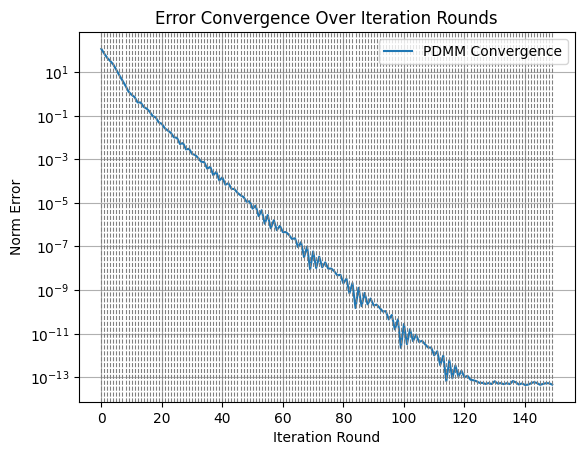

<Figure size 1000x400 with 0 Axes>

In [1205]:
if __name__ == '__main__':
    main()